
 Tuning LogisticRegression...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 10 is smaller than n_iter=15. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best AUC-ROC (CV): 0.8774

 Tuning RandomForest...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=15. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best AUC-ROC (CV): 0.9591

 Tuning XGBoost...
Best AUC-ROC (CV): 0.9624
\ LogisticRegression Results:
Accuracy : 0.8117
Precision: 0.8237
Recall   : 0.7881
F1 Score : 0.8055
AUC-ROC  : 0.8801

Confusion Matrix:


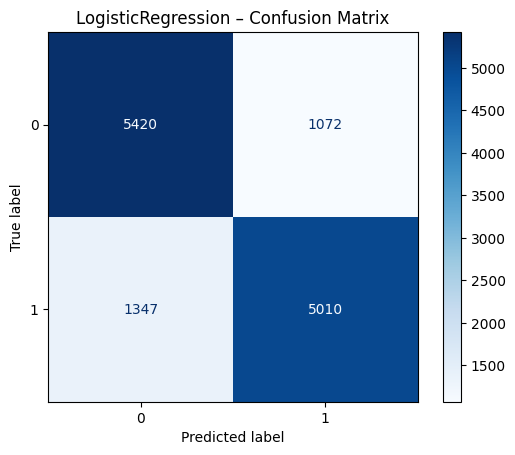

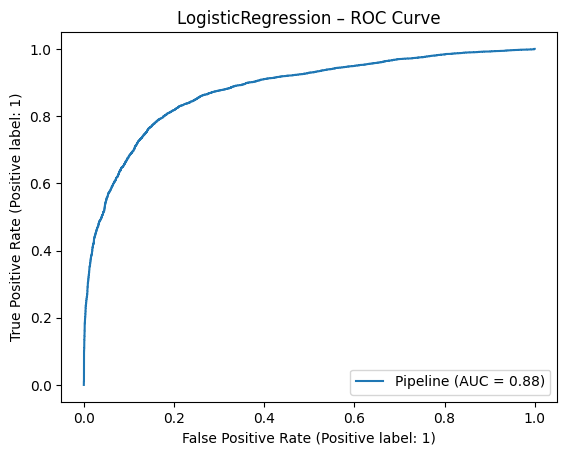

\ RandomForest Results:
Accuracy : 0.9009
Precision: 0.9530
Recall   : 0.8413
F1 Score : 0.8936
AUC-ROC  : 0.9618

Confusion Matrix:


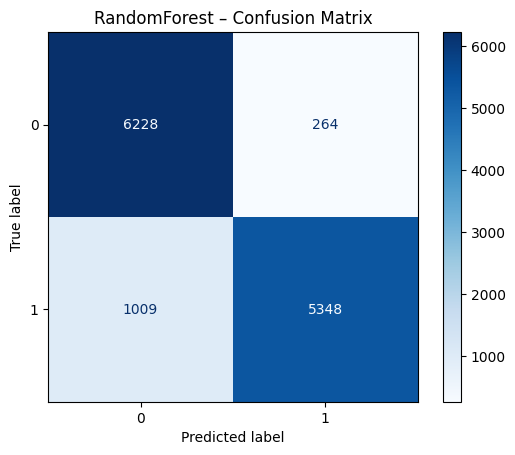

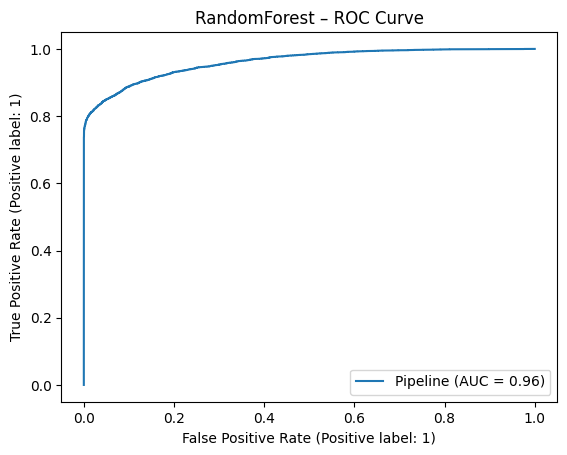

\ XGBoost Results:
Accuracy : 0.9045
Precision: 0.9487
Recall   : 0.8531
F1 Score : 0.8984
AUC-ROC  : 0.9646

Confusion Matrix:


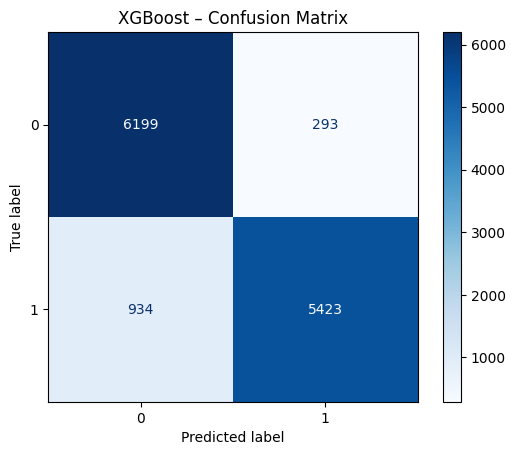

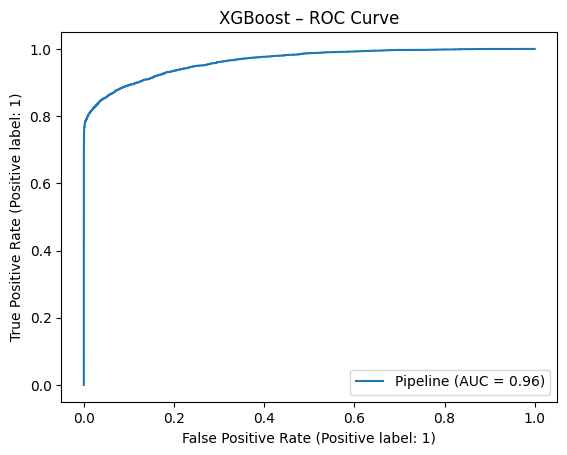

In [1]:
import pandas as pd
import numpy as np
import os, joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
XGB_OK = True

#  Load and inspect the dataset.
df = pd.read_csv('/kaggle/input/data-fake/user_fake_authentic_2class.csv')

# Convert categorical data into numerical format.
df['label'] = df['class'].map({'f': 1, 'r': 0})

# Handle missing values and remove duplicate accounts.
df = df.drop(columns=['class']).drop_duplicates().dropna()

# Basic Feature Engineering
df["followers_per_post"] = df["flw"] / (df["pos"] + 1)
df["likes_per_follower"] = df["lt"] / (df["flw"] + 1)
df["engagement_rate"] = (df["erl"] + df["erc"]) / (df["flw"] + 1)

# Prepare features and target
X = df.drop(columns=["label"])
y = df["label"]
features = X.columns.tolist()

# Normalize or scale numerical features if necessary.
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), features)
])

# Split the dataset into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)



# Train at least three different classification models,
models = {
    "LogisticRegression": Pipeline([
        ("prep", preprocessor),
        ("clf", LogisticRegression(max_iter=2000, random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

param_grids = {
    "LogisticRegression": {
        "clf__C": np.logspace(-3, 3, 10),
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    },
    "RandomForest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [10, 20],
        "clf__min_samples_split": [2],

    }
}

if XGB_OK:
    models["XGBoost"] = Pipeline([
        ("prep", preprocessor),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            use_label_encoder=False,
            random_state=42
        ))
    ])
    param_grids["XGBoost"] = {
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [4, 6],
        "clf__learning_rate": [0.05, 0.1],
        "clf__subsample": [0.8, 1.0]
    }

# Hyperparameter Tuning:
best_models = {}
for name, pipeline in models.items():
    print(f"\n Tuning {name}...")
    tuner = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grids[name],
        n_iter=15,
        cv=3,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    tuner.fit(X_train, y_train)
    best_models[name] = tuner.best_estimator_
    print(f"Best AUC-ROC (CV): {tuner.best_score_:.4f}")

# Evaluate models using:
# Accuracy, Precision, Recall, F1-score, and Confusion Matrix.
# Use AUC-ROC Curve to analyze model performance.
# Identify feature importance to determine which factors contribute most to fake profile detection.

    
def evaluate(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\ {name} Results:")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba):.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()
    
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} – ROC Curve")
    plt.show()

for name, model in best_models.items():
    evaluate(name, model, X_test, y_test)

#  Save models 
SAVE_DIR = "/kaggle/working/"
os.makedirs(SAVE_DIR, exist_ok=True)


for name, model in best_models.items():
    path = os.path.join(SAVE_DIR, f"{name}_model.pkl")
    joblib.dump(model, path)

